In [46]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from IPython.display import Math
import datetime
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueError)

In [47]:
df = pd.read_csv('G:/My Drive/IN/Data/Data_Standard/kind_forecast_train.csv',
                 parse_dates=['ds'])
df_test = pd.read_csv('G:/My Drive/IN/Data/Data_Standard/kind_forecast_test.csv',
                 parse_dates=['ds'])
dates = pd.read_csv('G:/My Drive/IN/Data/Forecast_Comparisons/dates.csv',
                      parse_dates=['Date'])
df = df.rename(columns={'ds': 'week', 'y': 'sales'})
df_test = df_test.rename(columns={'ds': 'week', 'y': 'sales'})

In [48]:
df = df.drop_duplicates(subset=['sales', 'week'])
df['week'] = df['week'] = pd.to_datetime(df['week'])
df = df.sort_values(by=['week'])
df['sales'] = df['sales'].values
df['index'] = df['week']
df.set_index('index', inplace=True)
df = df[['week','sales']]

The following metrics are excellent in different situations; for example, RMSE is
excellent for comparing similar models.

In [49]:
def forecast_accuracy(forecast, Actuals):
    mape = np.mean(np.abs(forecast - Actuals)/np.abs(Actuals))  # MAPE
    mae = np.mean(np.abs(forecast - Actuals))    # MAE
    mse = np.square(np.subtract(Actuals,forecast)).mean()
    rmse = np.mean((forecast - Actuals)**2)**.5  # RMSE
    return({'MAPE':mape, 'MSE':mse, 'MAE': mae, 'RMSE':rmse})

There are three parameters of interest for an ARIMA model: d,p, and q. D refers to
differencing each previous value to make the model stationary. P is the term used
for how many lags can be used for prediction. Q is the order of moving average
to improve the model.

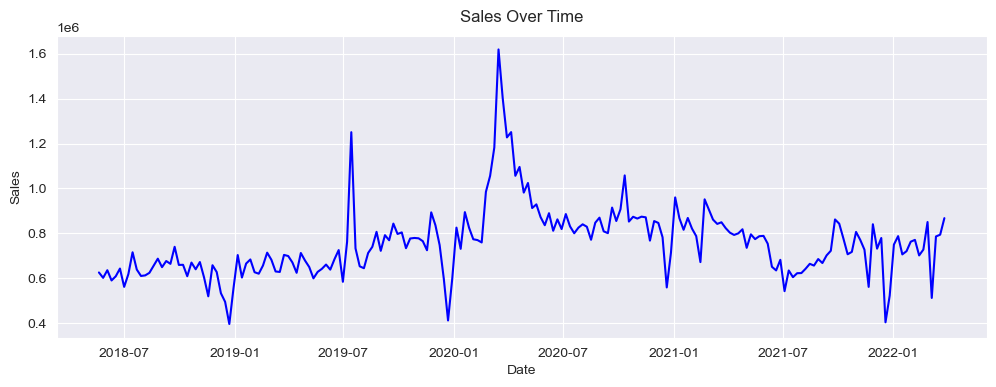

In [50]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(12, 4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, df['week'], df['sales'], title='Sales Over Time')

An increasing trend is clearly visible, though the sesaonality is not
quite as obvious, so we will test for it later.

The Augmented Dickey-Fuller Test checks for the important
condition of stationarity. This test has failed, meaning we have to
correct for non-stationarity.

In [51]:
adf_test = ADFTest(alpha = .05)
adf_test.should_diff(df['sales'])

(0.1670476032405463, True)

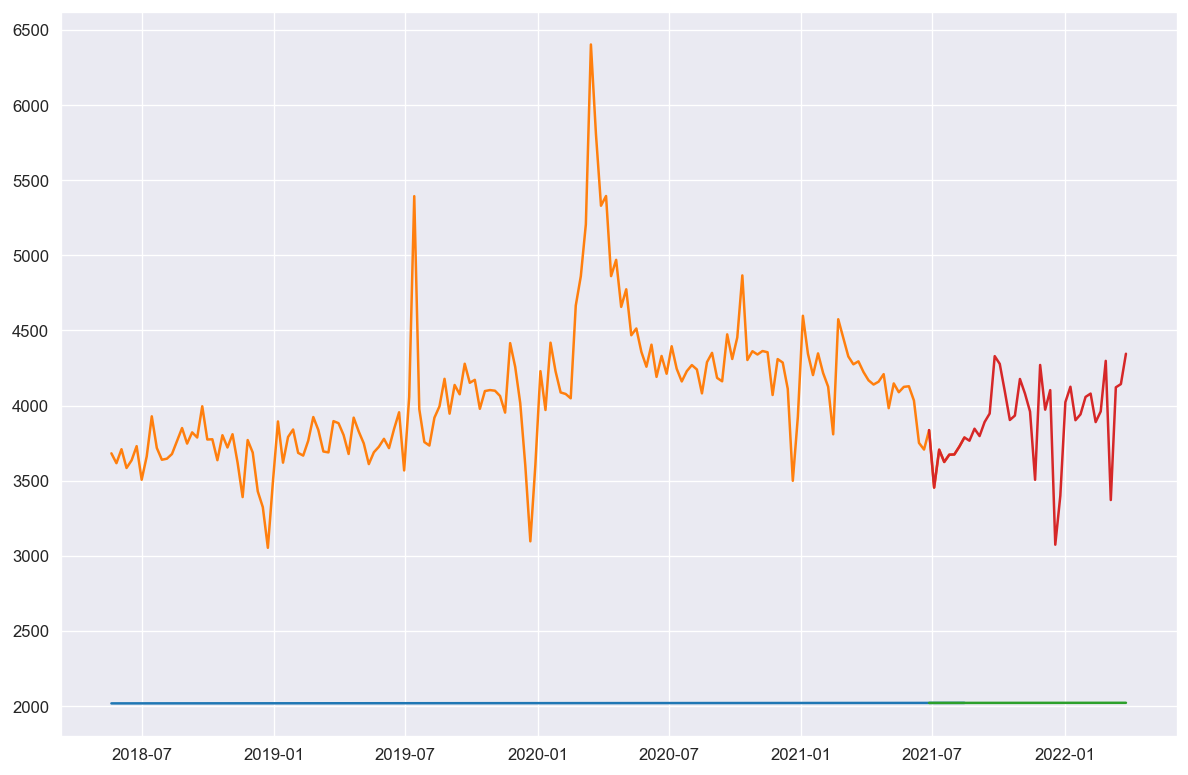

In [52]:
train = df[:170]
test = df[-40:]
plt.plot(train)
plt.plot(test)

Value = Base Level + Trend + Seasonality + Error - Additive Decomposition
Value = Base Level x Trend x Seasonality x Error - Multiplicative Decompisition

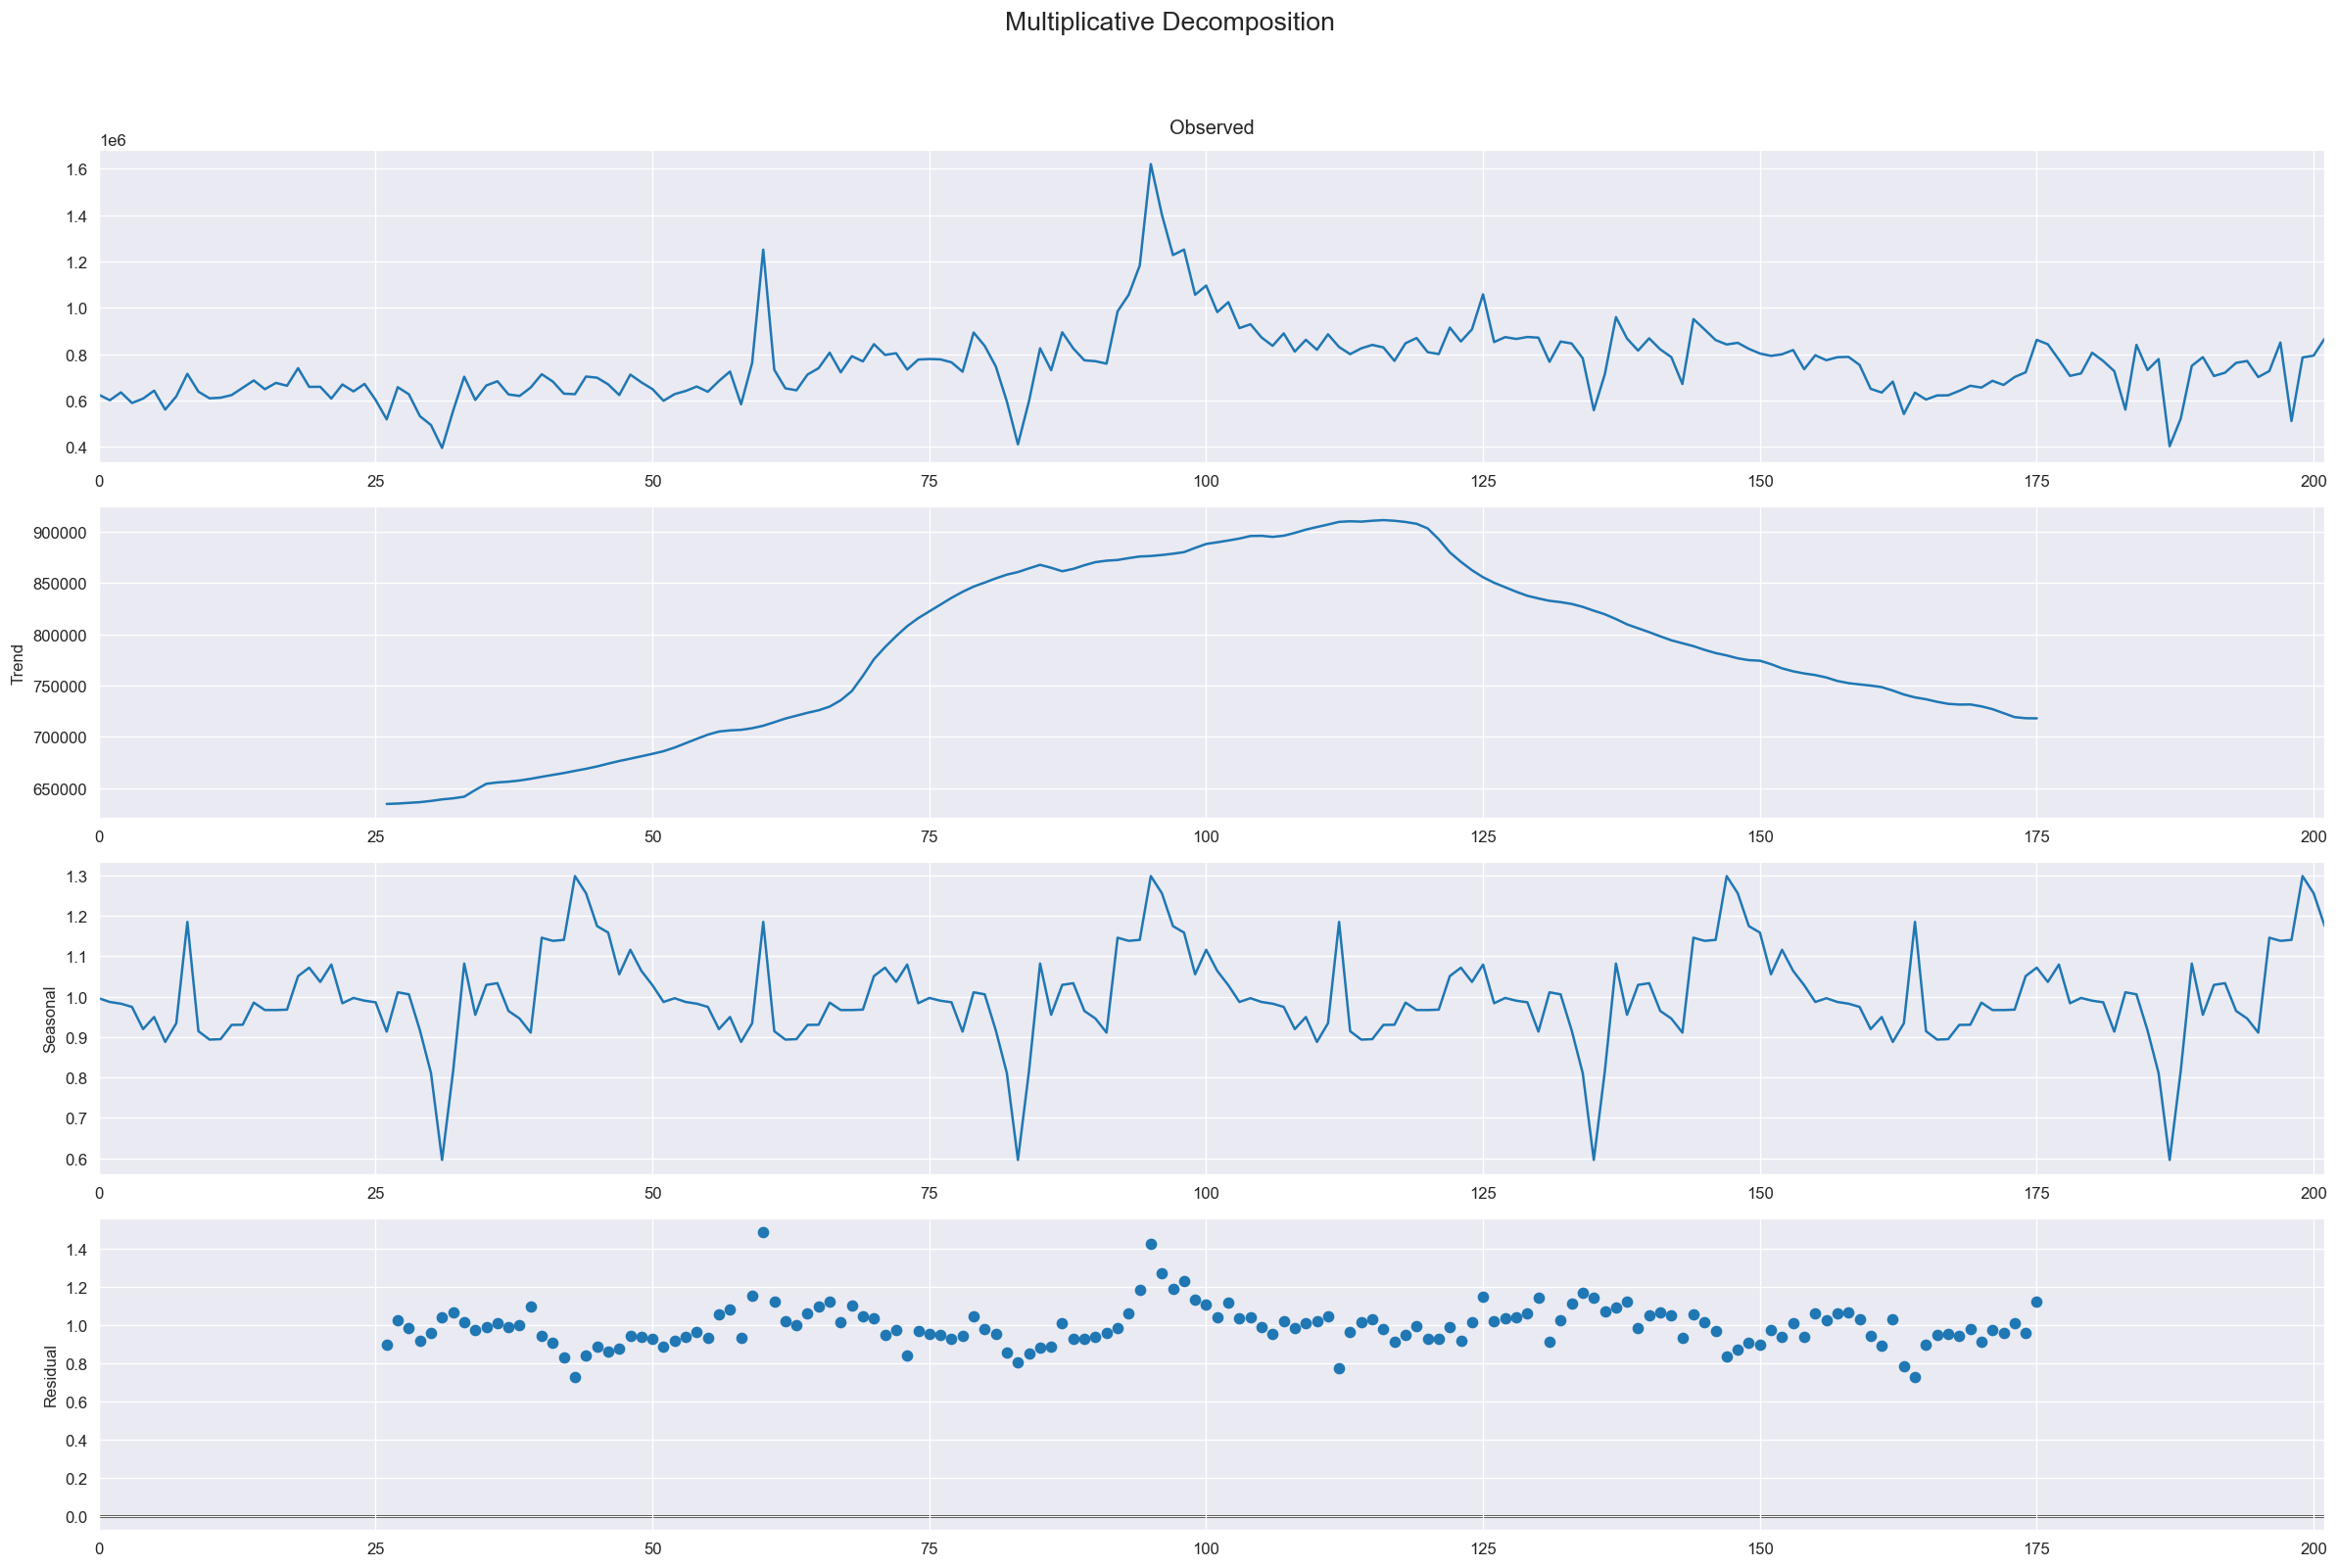

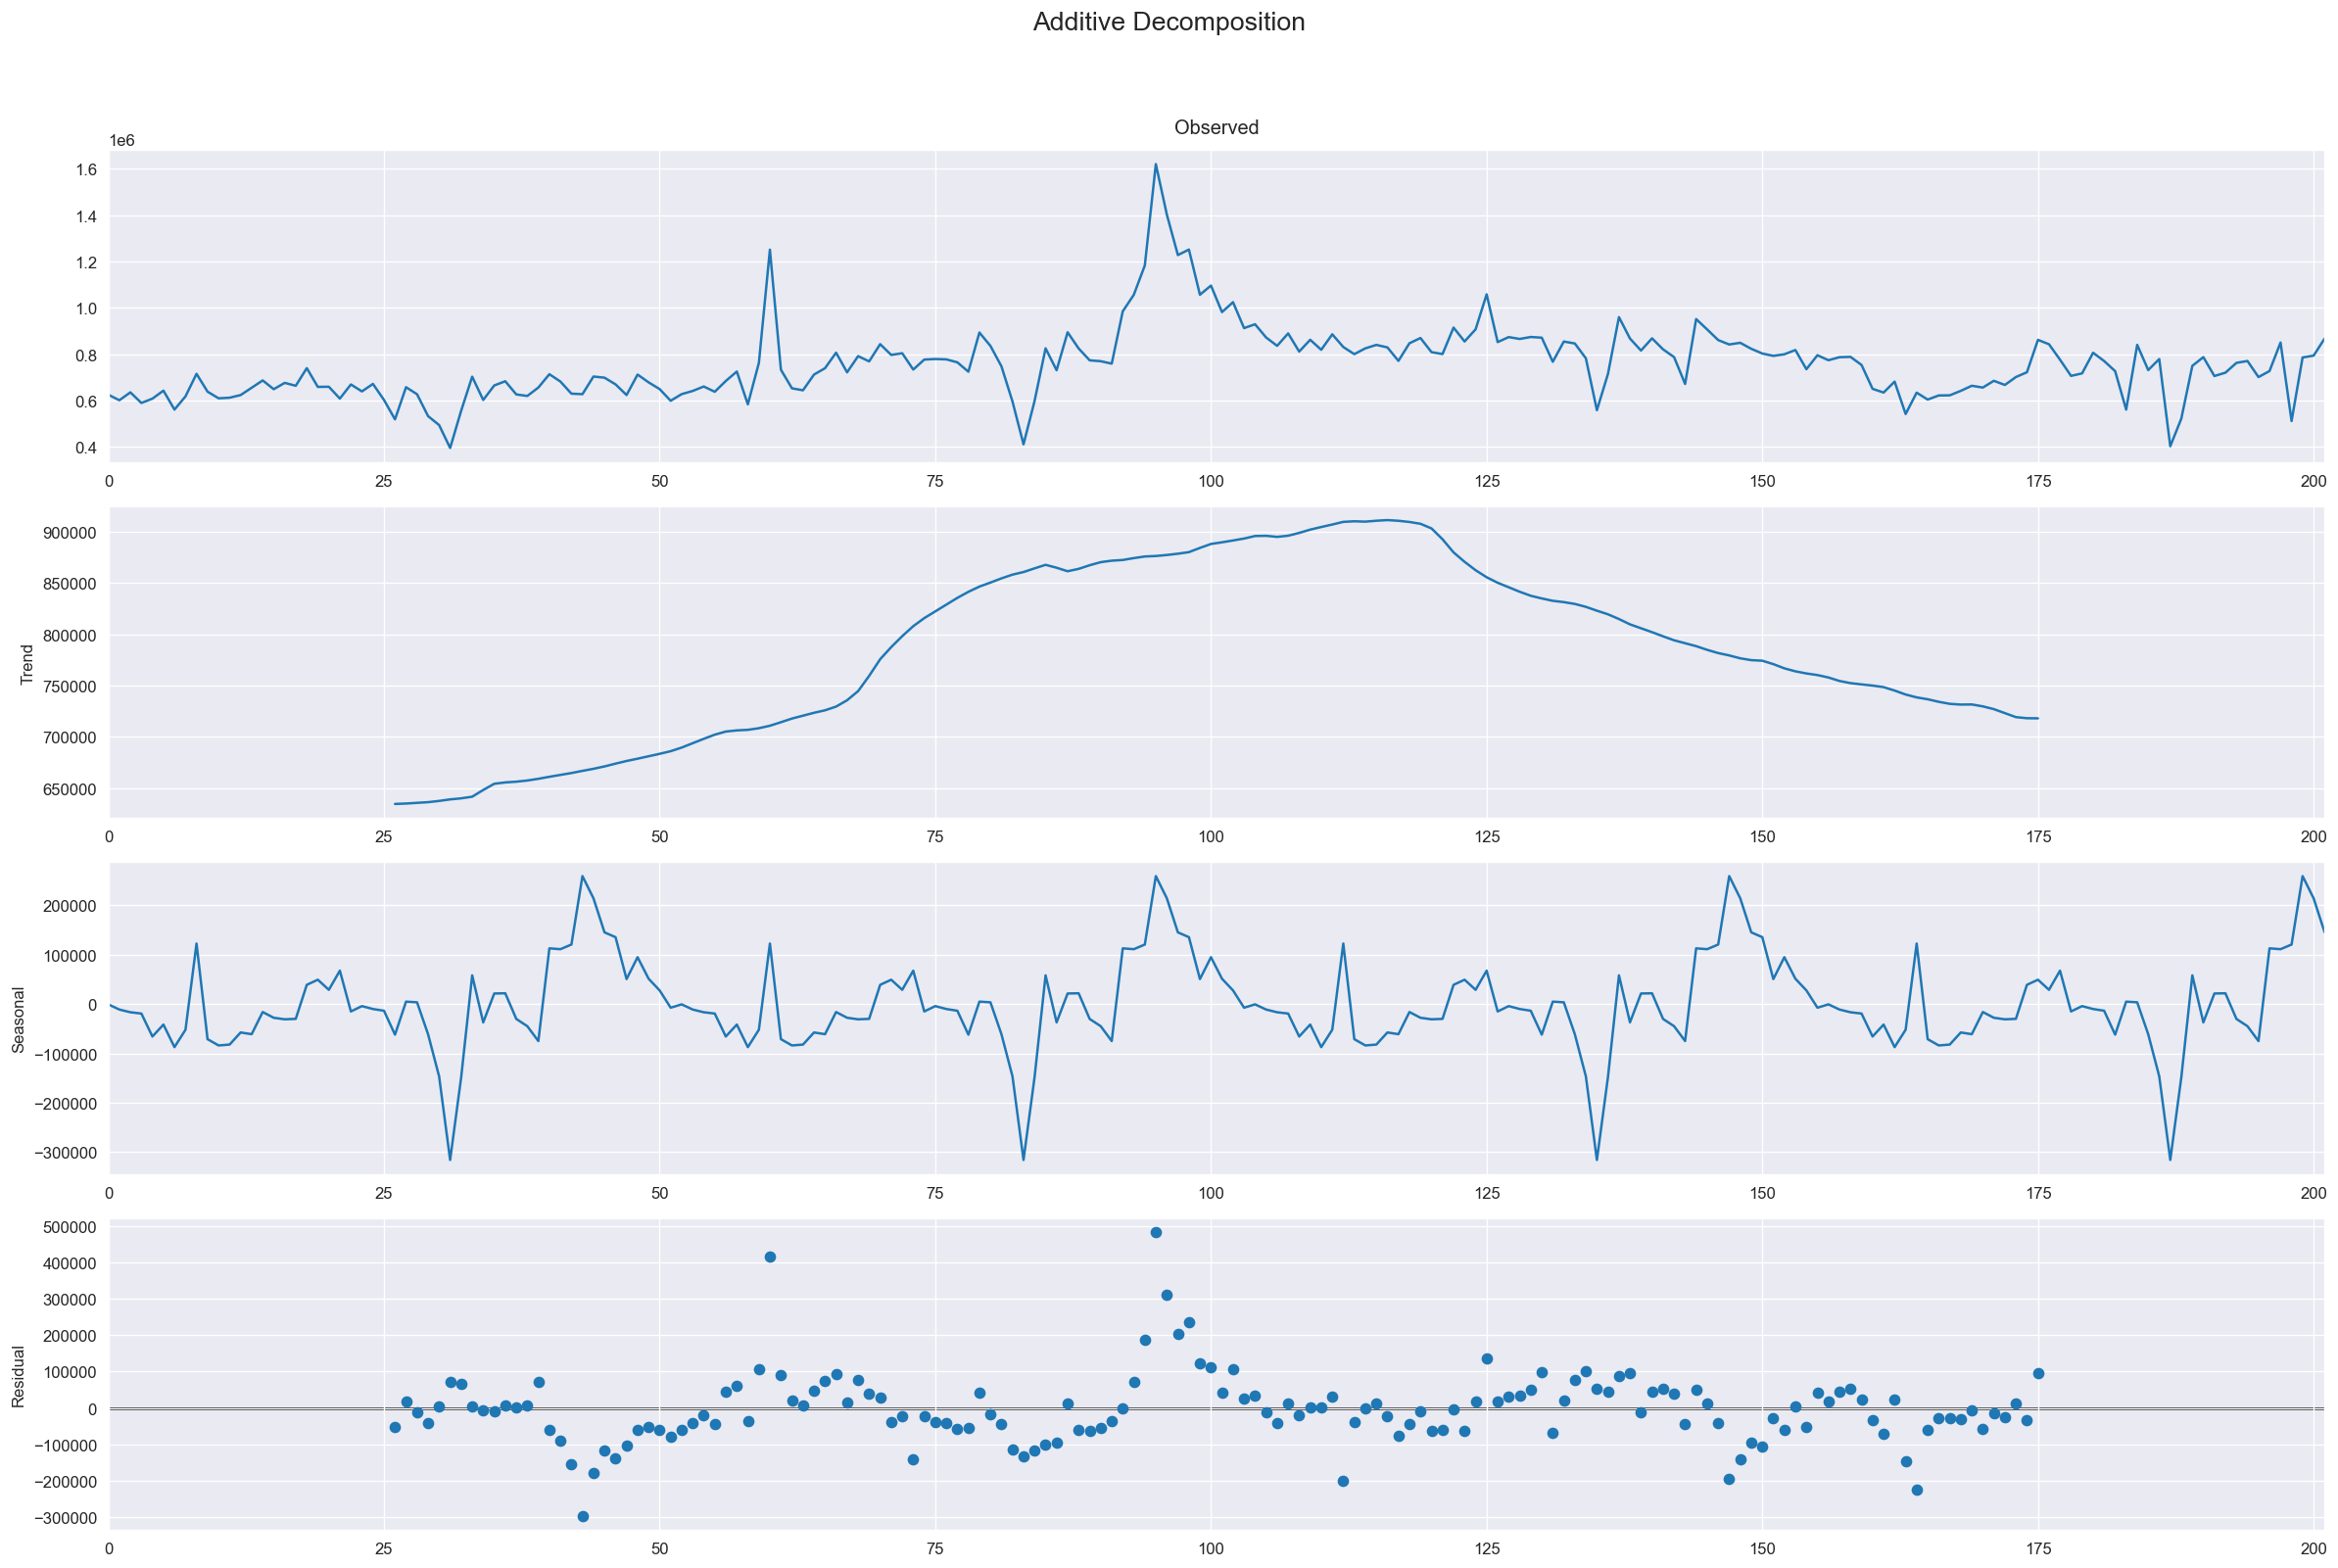

In [53]:
multiplicative_decomposition = seasonal_decompose(df['sales'].values,
                                                  model='multiplicative',
                                                  period=52)
additive_decomposition = seasonal_decompose(df['sales'].values, model='additive',
                                            period=52)
plt.rcParams.update({'figure.figsize': (20,14)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Both plots have a positive trend and display some seasonality, but the additive
seems to have significantly better reesiduals.

Text(0.5, 1.0, 'Sales Detrended')

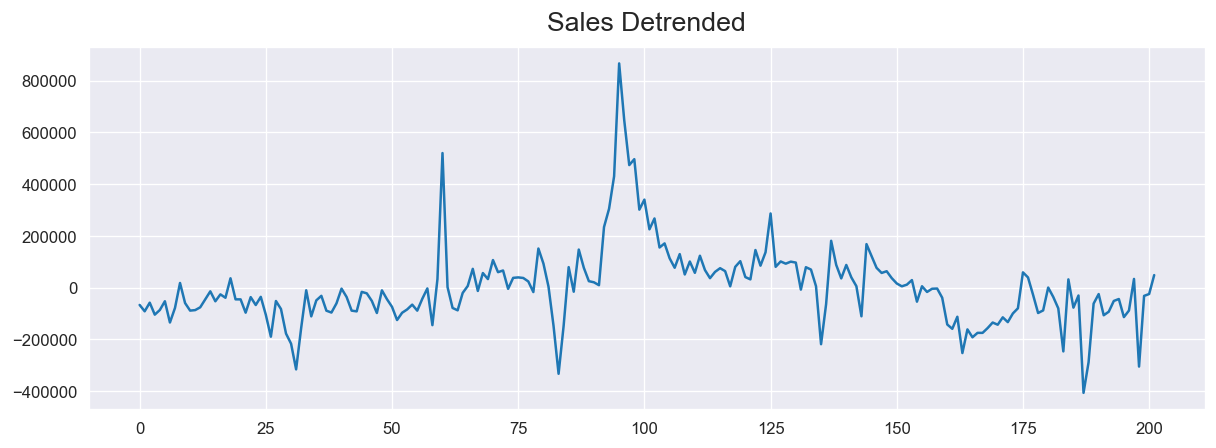

In [54]:
detrended = signal.detrend(df['sales'].values)
plt.rcParams.update({'figure.figsize': (12,4)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

The plot no longer seems to be increasing in trend, hence we have detrended it.

[]

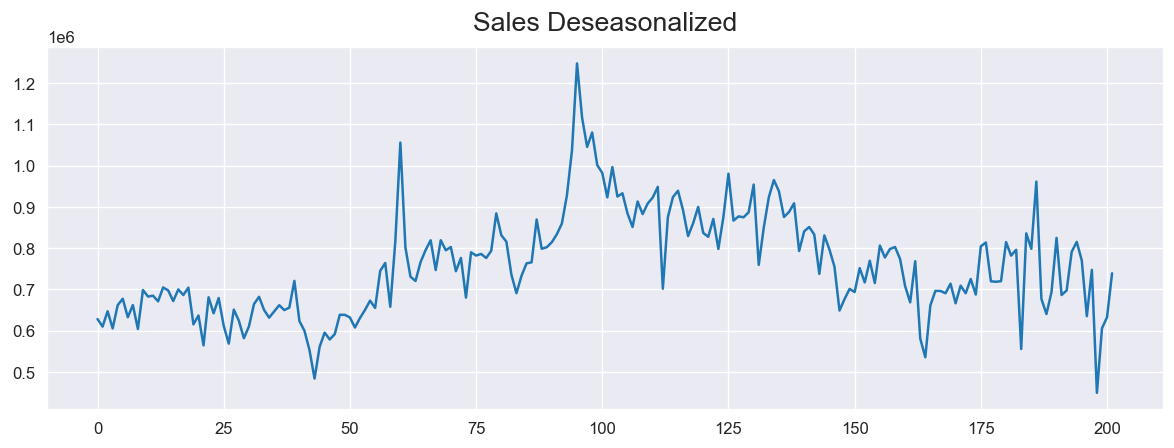

In [55]:
result_mul = seasonal_decompose(df['sales'].values, model='multiplicative', period=52)
deseasonalized = df['sales'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Sales Deseasonalized', fontsize=16)
plt.plot()

The plot does not show a strong removal of seasonality, so move on to some testing

The following plot does not have any drastic spikes that suggest strong seasonality.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

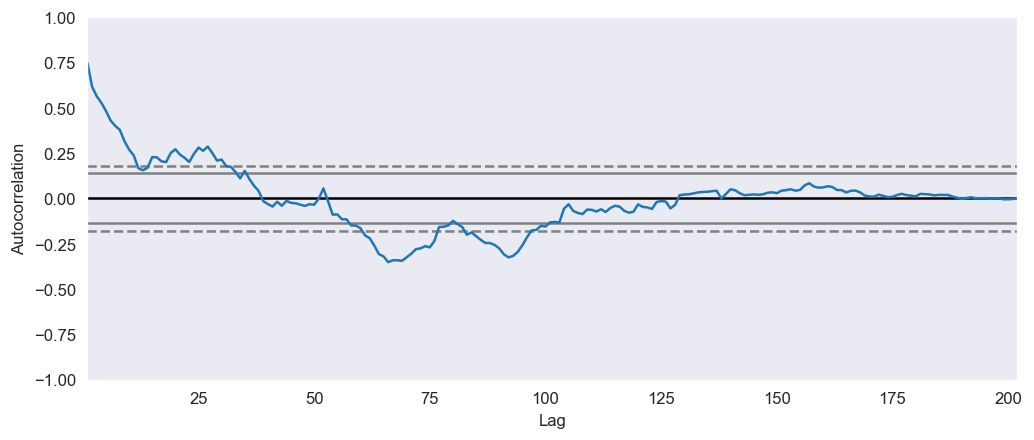

In [56]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df['sales'].tolist())

Autocorrelation refers to correlation of a series to its own lags. Partial autocorrelation
refers to the correlation to a lag without reference to the lags between.

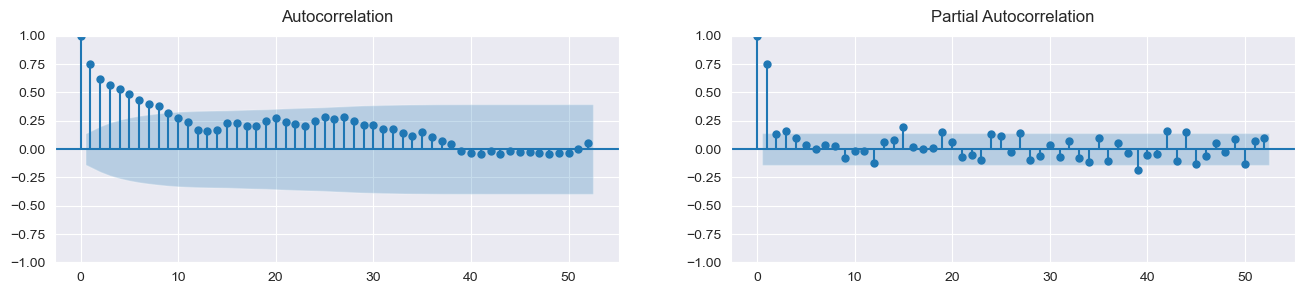

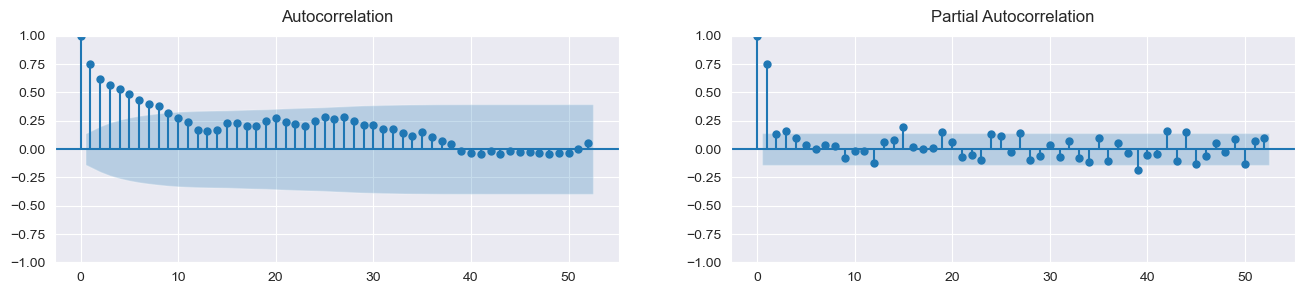

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(df['sales'].tolist(), lags=52, ax=axes[0])
plot_pacf(df['sales'].tolist(), lags=52, ax=axes[1])

Along with the above plots, the following metrics will quantify each degree of
lag. Perfect autocorrelation is one, and positive means that the next value in
the series will likely be higher.

In [58]:
ac1 = df['sales'].autocorr(lag=1)
print("One week Lag: ", ac1)
ac2 = df['sales'].autocorr(lag=2)
print("Two week Lag: ", ac2)
ac3 = df['sales'].autocorr(lag=3)
print("Three week Lag: ", ac3)
ac4 = df['sales'].autocorr(lag=4)
print("Four Week Lag: ", ac4)
ac5 = df['sales'].autocorr(lag=5)
print("Five Week Lag: ", ac5)
ac6 = df['sales'].autocorr(lag=6)
print("Six Week Lag: ", ac6)
ac7 = df['sales'].autocorr(lag=7)
print("Seven Week Lag: ", ac7)
ac8 = df['sales'].autocorr(lag=8)
print("Eight Week Lag: ", ac8)
ac9 = df['sales'].autocorr(lag=9)
print("Nine Week Lag: ", ac9)
ac10 = df['sales'].autocorr(lag=10)
print("Ten Week Lag: ", ac10)
ac11 = df['sales'].autocorr(lag=11)
print("Eleven Week Lag: ", ac11)
ac12 = df['sales'].autocorr(lag=12)
print("Twelve Week Lag: ", ac12)

One week Lag:  0.7506264204218593
Two week Lag:  0.620557680700574
Three week Lag:  0.5681501342530226
Four Week Lag:  0.5367082737540644
Five Week Lag:  0.49217321715171825
Six Week Lag:  0.43940122563715567
Seven Week Lag:  0.41083532677750706
Eight Week Lag:  0.3889905311040949
Nine Week Lag:  0.32501218904699025
Ten Week Lag:  0.27795191092140825
Eleven Week Lag:  0.24505039266479609
Twelve Week Lag:  0.17242500566717842


These twelve weeks rather strong logs show that autocorrelation is somethng to
be mindful in this model.

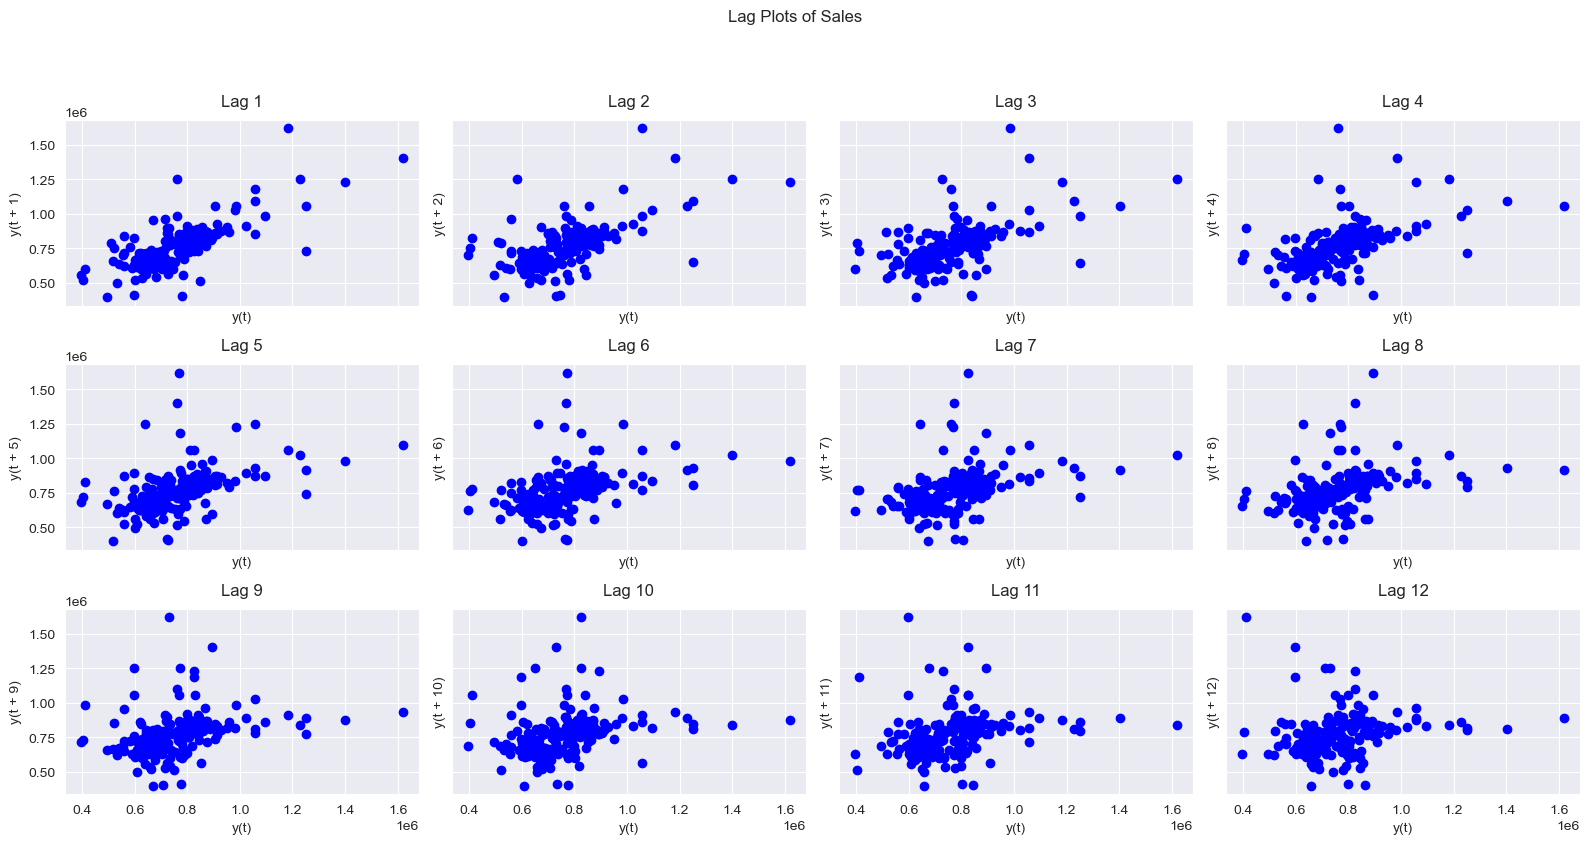

In [59]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:12]):
    lag_plot(df['sales'], lag=i+1, ax=ax, c='blue')
    ax.set_title('Lag ' + str(i+1))
fig.suptitle('Lag Plots of Sales', y=1.05)
fig.tight_layout()
plt.show()

Decreasing linear trend between lag plots demonstrates similar results to
lag scores, suggesting some positive autocorrelation between first week

In [60]:
train = df['sales'][:105]
test = df['sales'][105:]
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2726.845, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2728.034, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2727.550, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2726.477, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2726.102, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2724.150, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2725.679, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2726.096, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2724.460, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2726.126, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2721.815, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2724.672, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2725.677, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2723.640, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]          

SARIMAX MODEL

C:\Users\norri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\norri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


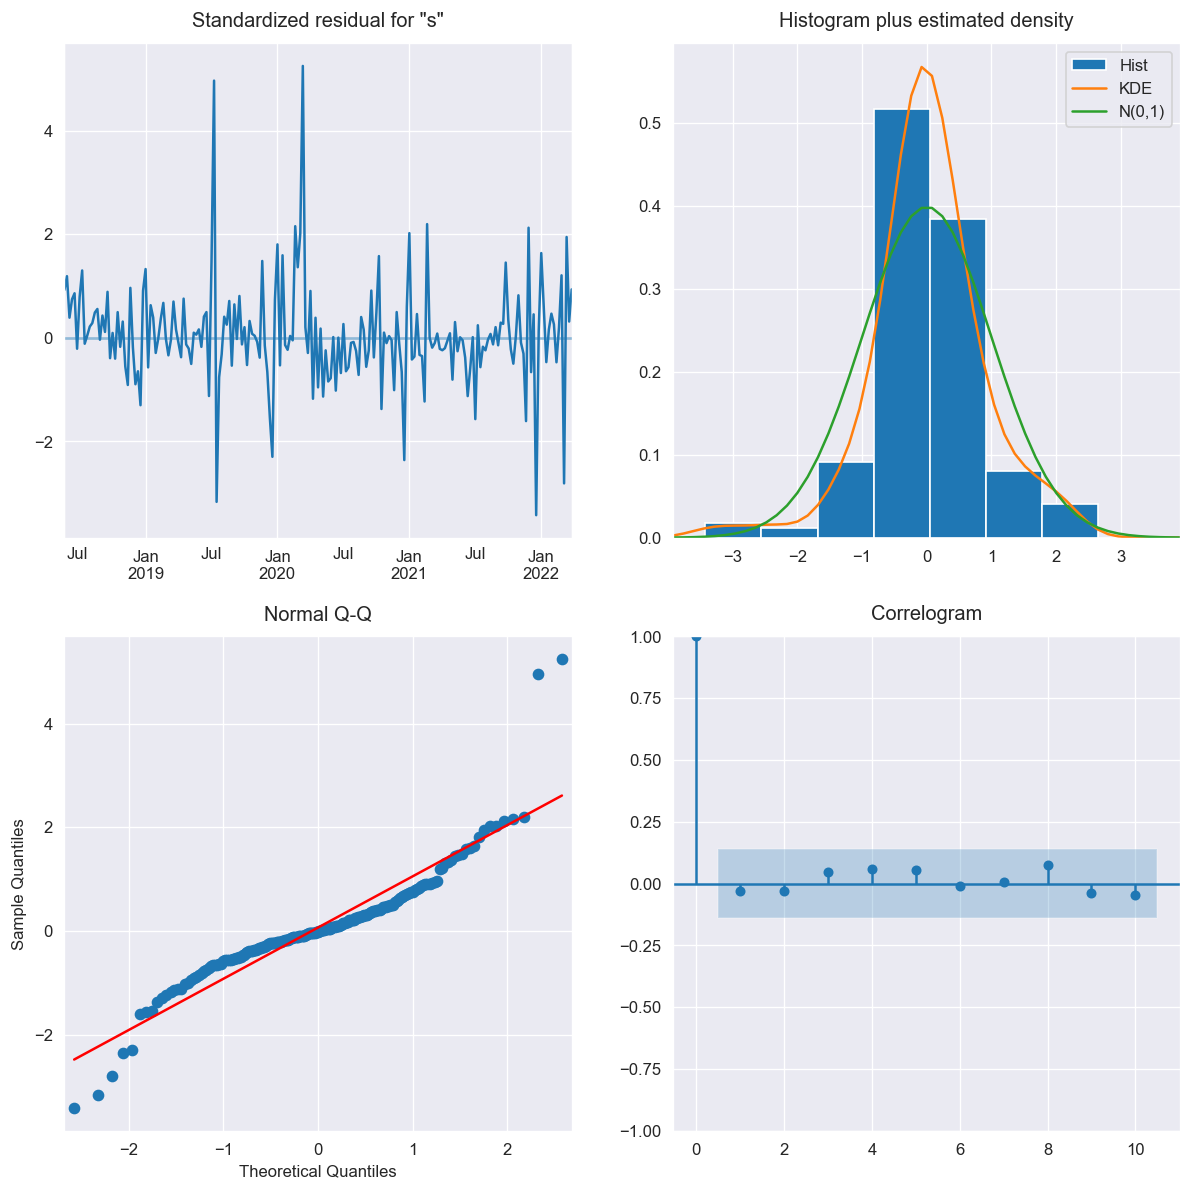

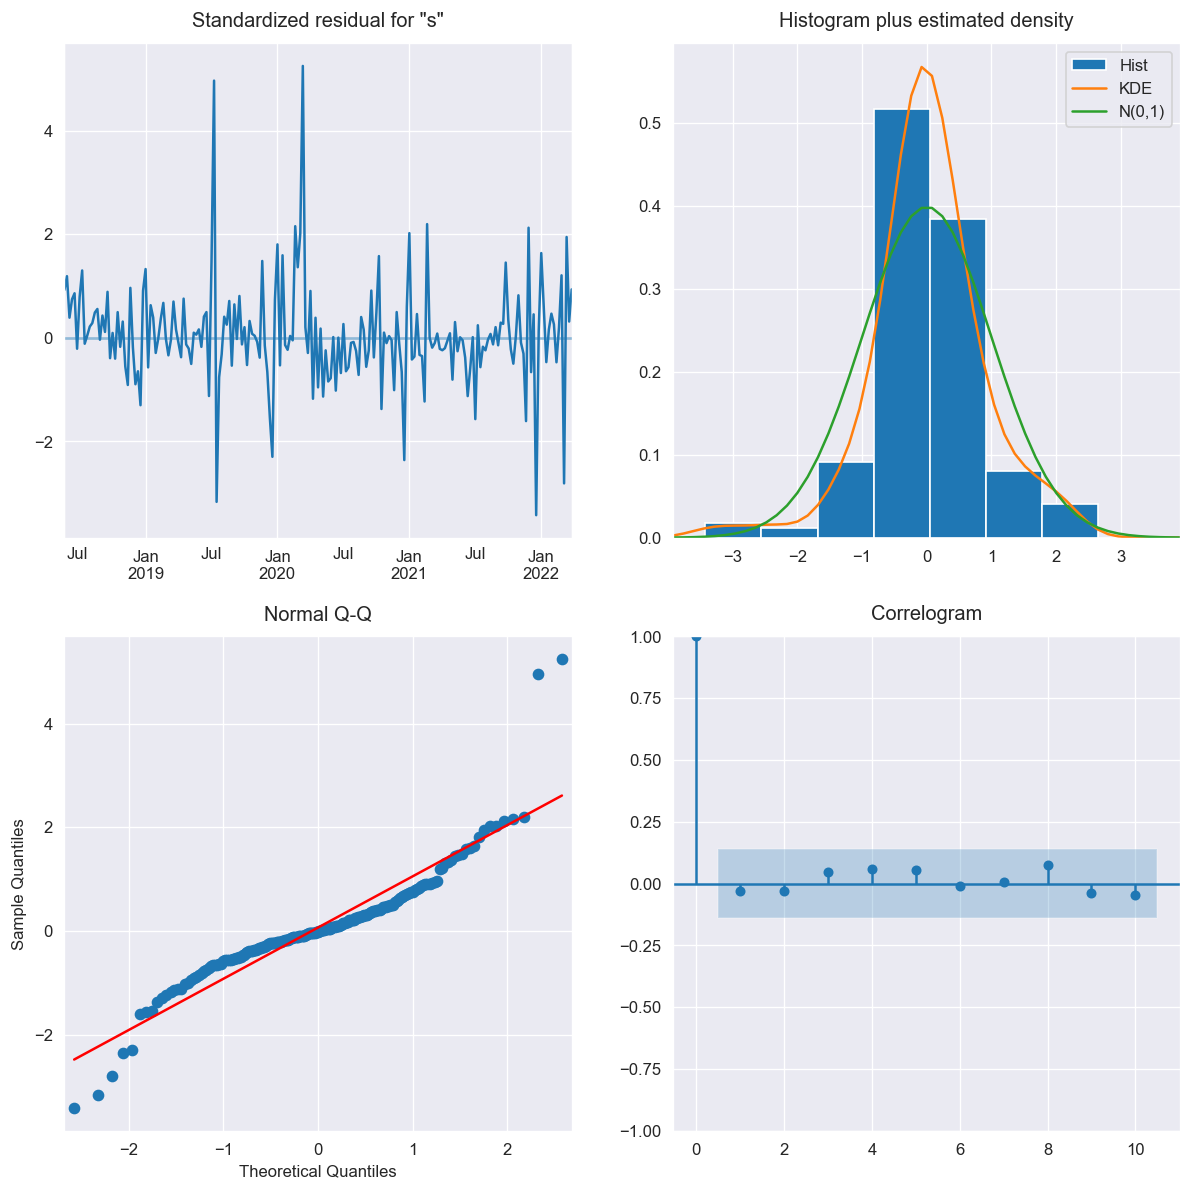

In [61]:
mod = sm.tsa.statespace.SARIMAX(df['sales'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
results.plot_diagnostics(figsize=(12, 12))

SARIMAX Diagnostics

In [62]:
forecast = forecast.squeeze()
forecast_accuracy(forecast, test)

{'MAPE': 0.3085094427716464,
 'MSE': 57862447322.96277,
 'MAE': 216722.57649763214,
 'RMSE': 240546.14385386178}

In [63]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  202
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2607.900
Date:                Thu, 01 Sep 2022   AIC                           5221.800
Time:                        07:33:07   BIC                           5231.710
Sample:                    05-20-2018   HQIC                          5225.810
                         - 03-27-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5689      0.093      6.087      0.000       0.386       0.752
ma.L1         -0.8833      0.069    -12.815      0.000      -1.018      -0.748
sigma2       1.11e+10   1.94e-12   5.73e+21      0.000    1.11e+10    1.11e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               429.29
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.93
Prob(H) (two-sided):                  0.78   Kurtosis:                         9.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+37. Standard errors may be unstable.
"""

In [64]:
df_small = df[['week', 'sales']]

In [65]:
result = adfuller(df_small.sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.581393
p-value: 0.006127


In this case, we fail the ADF test and will examine differencing
as a method to make our series stationary,

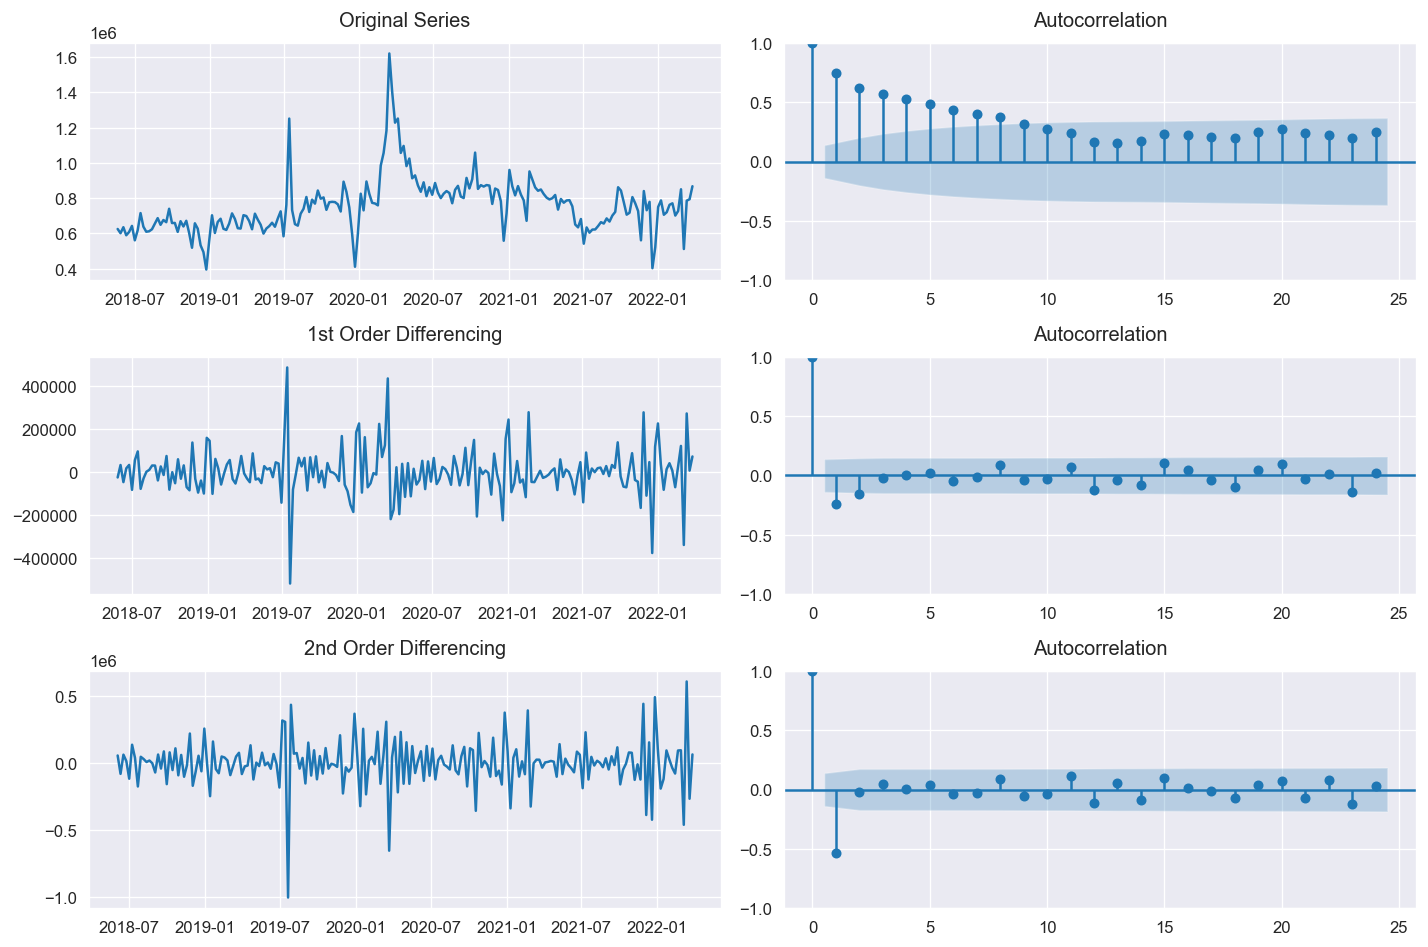

In [66]:
plt.rcParams.update({'figure.figsize':(12,8), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df_small.sales); axes[0, 0].set_title('Original Series')
plot_acf(df_small.sales, ax=axes[0, 1])

axes[1, 0].plot(df_small.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_small.sales.diff().dropna(), ax=axes[1, 1])

axes[2, 0].plot(df_small.sales.diff().diff()); axes[2, 0].set_title('2nd Order '
                                                                  'Differencing')
plot_acf(df_small.sales.diff().diff().dropna(), ax=axes[2, 1])
fig.tight_layout()
plt.show()

By the time the first differencing plot and its correlation plot, we can see
that the model has achieved a decent amount of stationarity.

In [67]:
# Fix Training and Test Data for Remaining Functions
df_small = df_small.sort_values(by=['week'])
df_model = df_small.set_index('week')
df_small = df_small.reset_index()
df_small = df_small[['week', 'sales']]
train = df_small['sales'][:105]
test = df_small['sales'][105:]
train_model = df_model['sales'][:186]
test_model = df_model['sales'][-16:]

Now we will test the auto_arima model to see if it performs better.

In [68]:
train = df_model['sales']
mod_auto_arima = auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,
                         max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                         max_P=5, max_D=5, max_Q=5, m=12, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5086.270, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5024.701, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4991.238, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5075.466, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4990.667, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5021.703, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4992.095, Time=0.58 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4991.262, Time=1.10 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4990.155, Time=0.52 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=4991.511, Time=0.93 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=4993.457, Time=1.57 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=4983.392, Time=0.33 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=4964.671, Time=0.82 sec
 ARIMA(0,1,0)(1,1,1)[12]

In [69]:
train = df['sales'][-16:]
test = df['sales'][:16] # missing pass sixteen weeks
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = mod_auto_arima.predict(n_periods=16)
index = pd.date_range('2022-04-03', '2022-07-17', freq='w')
forecast = pd.DataFrame(forecast,index =index,columns=['Prediction'])
forecast = forecast.squeeze()
forecast_accuracy(forecast, test)
Auto_Arima = forecast_accuracy(forecast, test)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=435.996, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=424.610, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=426.567, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=433.219, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=479.238, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=436.196, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.137 seconds


In [70]:
train = df_model['sales'][:186]
test = df_model['sales'][186:202]
df_temp = df_test.set_index('week')
df_temp = df_temp[:16]

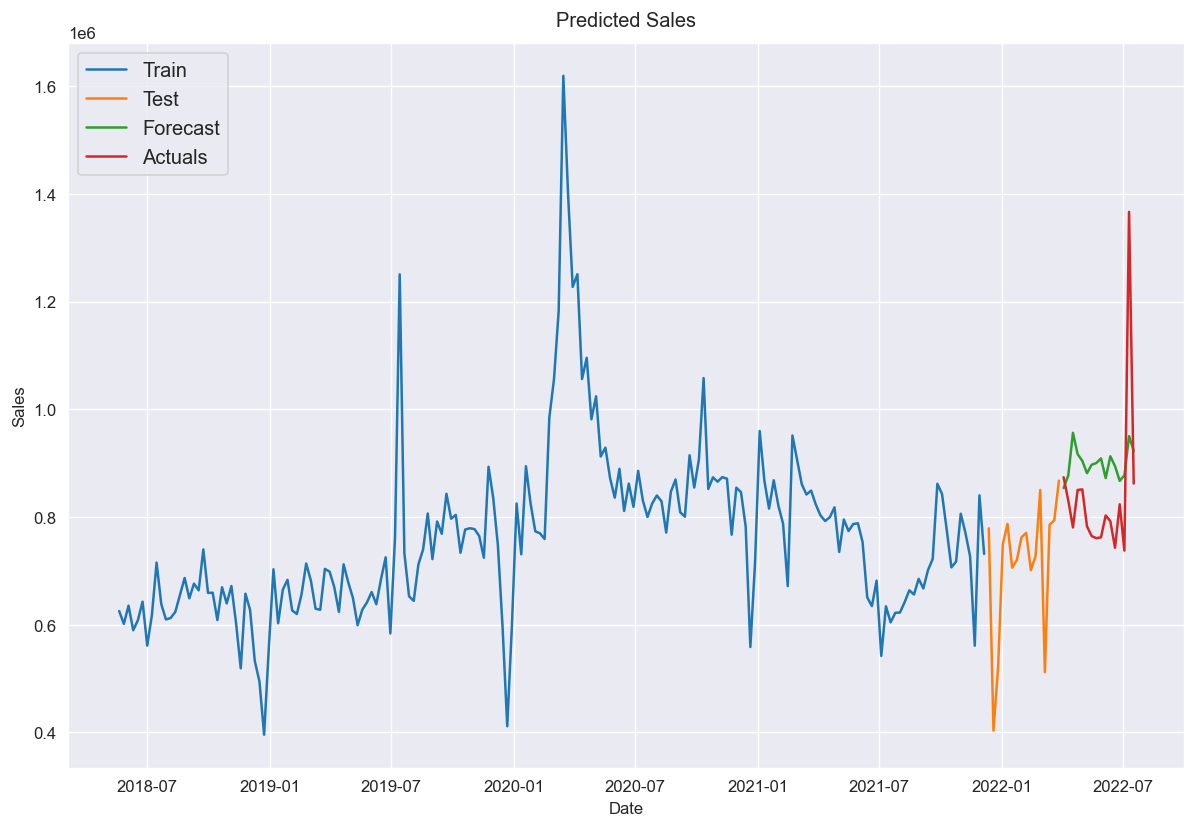

In [71]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.plot(df_temp, label='Actuals')
plt.title('Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=12)
fig.autofmt_xdate()
plt.show()

Now taking a look at the other predictions compared to actuals.

In [72]:
df_group = pd.read_csv('G:/My Drive/IN/Data/Forecast_Comparisons/updated_group_forecast2'
                       '.csv',
                       index_col="Date",parse_dates=True)
df_group.astype(float)
df_group['actuals'] = test.values

In [73]:
BigQuery = forecast_accuracy(df_group['BigQuery'], df_group['actuals'])
VertexAI = forecast_accuracy(df_group['VertexAI'], df_group['actuals'])
NeuralProphet = forecast_accuracy(df_group['NeuralProphet'], df_group['actuals'])
Prophet = forecast_accuracy(df_group['Prophet'], df_group['actuals'])
Forecast = forecast_accuracy(df_group['Amazon_Forecast'], df_group['actuals'])

In [74]:
error_frame = pd.DataFrame.from_dict(VertexAI, orient='index')
error_frame[2] = pd.DataFrame.from_dict(BigQuery, orient='index')
error_frame[3] = pd.DataFrame.from_dict(NeuralProphet, orient='index')
error_frame[4] = pd.DataFrame.from_dict(Prophet, orient='index')
error_frame[5] = pd.DataFrame.from_dict(Forecast, orient='index')
error_frame = error_frame.set_axis(['VertexAI', 'BigQuery', 'NeuralProphet',
                                    'Prophet', 'Amazon_Forecast'], axis=1, inplace=False)

In [75]:
x = df_group.index
Actuals = df_temp.squeeze()
VertexAI = df_group['VertexAI']
BigQuery = df_group['BigQuery']
NeuralProphet = df_group['NeuralProphet']
Forecast = df_group['Amazon_Forecast']
Prophet = df_group['Prophet']
NoPrime = df_group['NoPrime']

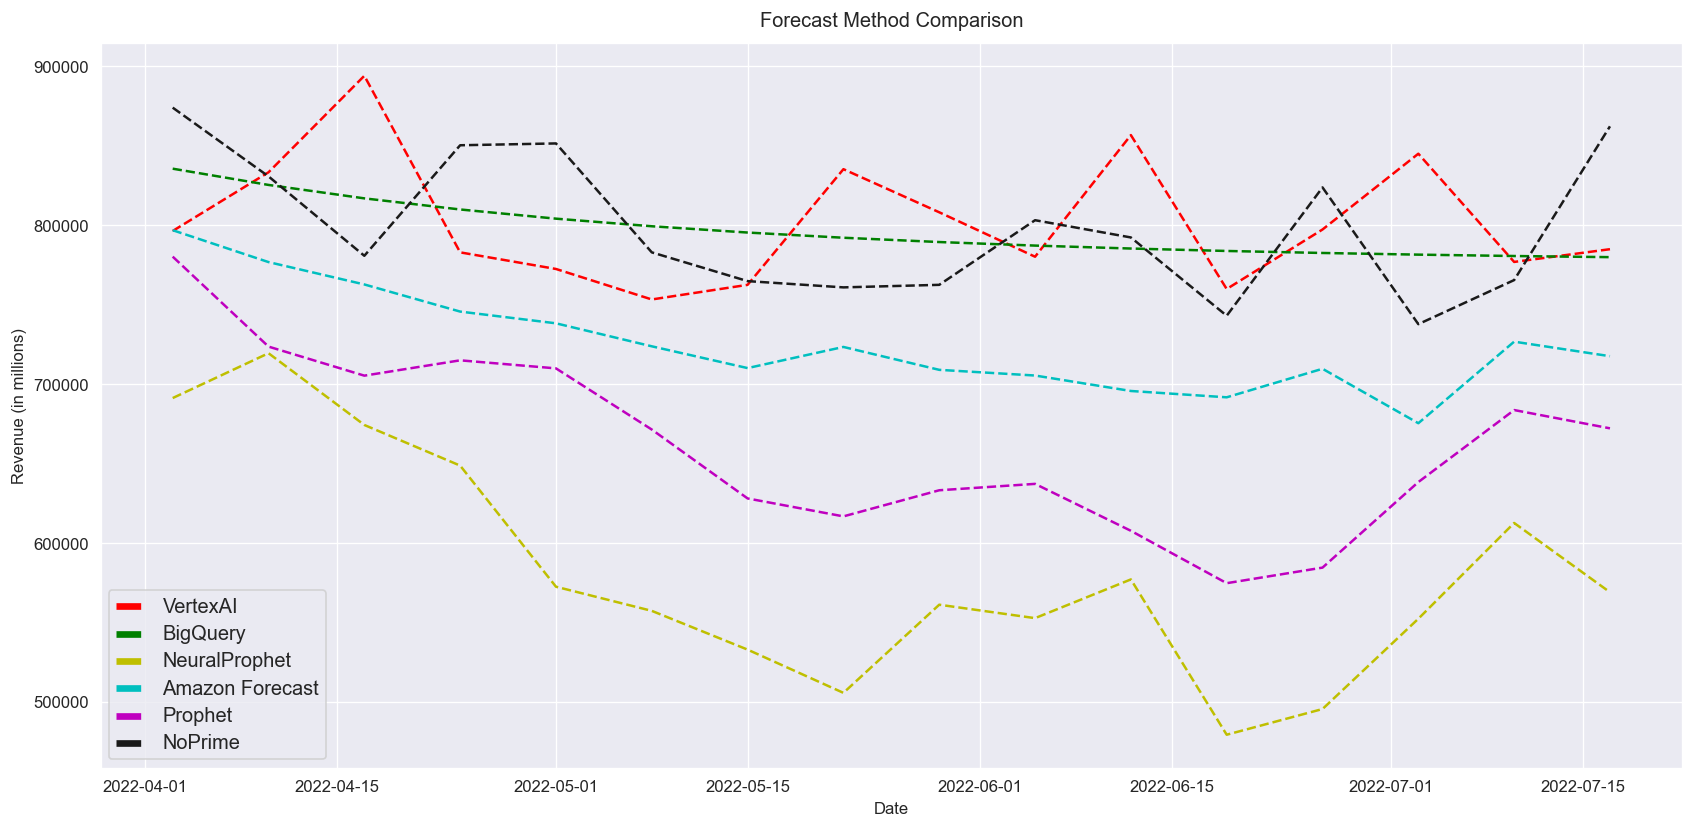

In [76]:
fig = plt.figure(figsize=(17, 8))
ax  = fig.add_subplot(111)
# ax.plot(x, Actuals, c='b', label='Actuals', linewidth=7)
ax.plot(x, VertexAI, c='r', linestyle='dashed',  label='VertexAI')
ax.plot(x, BigQuery, c='g', linestyle='dashed', label='BigQuery')
ax.plot(x, NeuralProphet, c='y', linestyle='dashed', label='NeuralProphet')
ax.plot(x, Forecast, c='c', linestyle='dashed', label='Amazon Forecast')
ax.plot(x, Prophet, c='m', linestyle='dashed', label='Prophet')
ax.plot(x, NoPrime, color = '0.1', linestyle='dashed', label='NoPrime')
leg = plt.legend()
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.setp(leg_texts, fontsize='large')
plt.xlabel('Date')
plt.ylabel('Revenue (in millions)')
plt.title('Forecast Method Comparison')
plt.show()

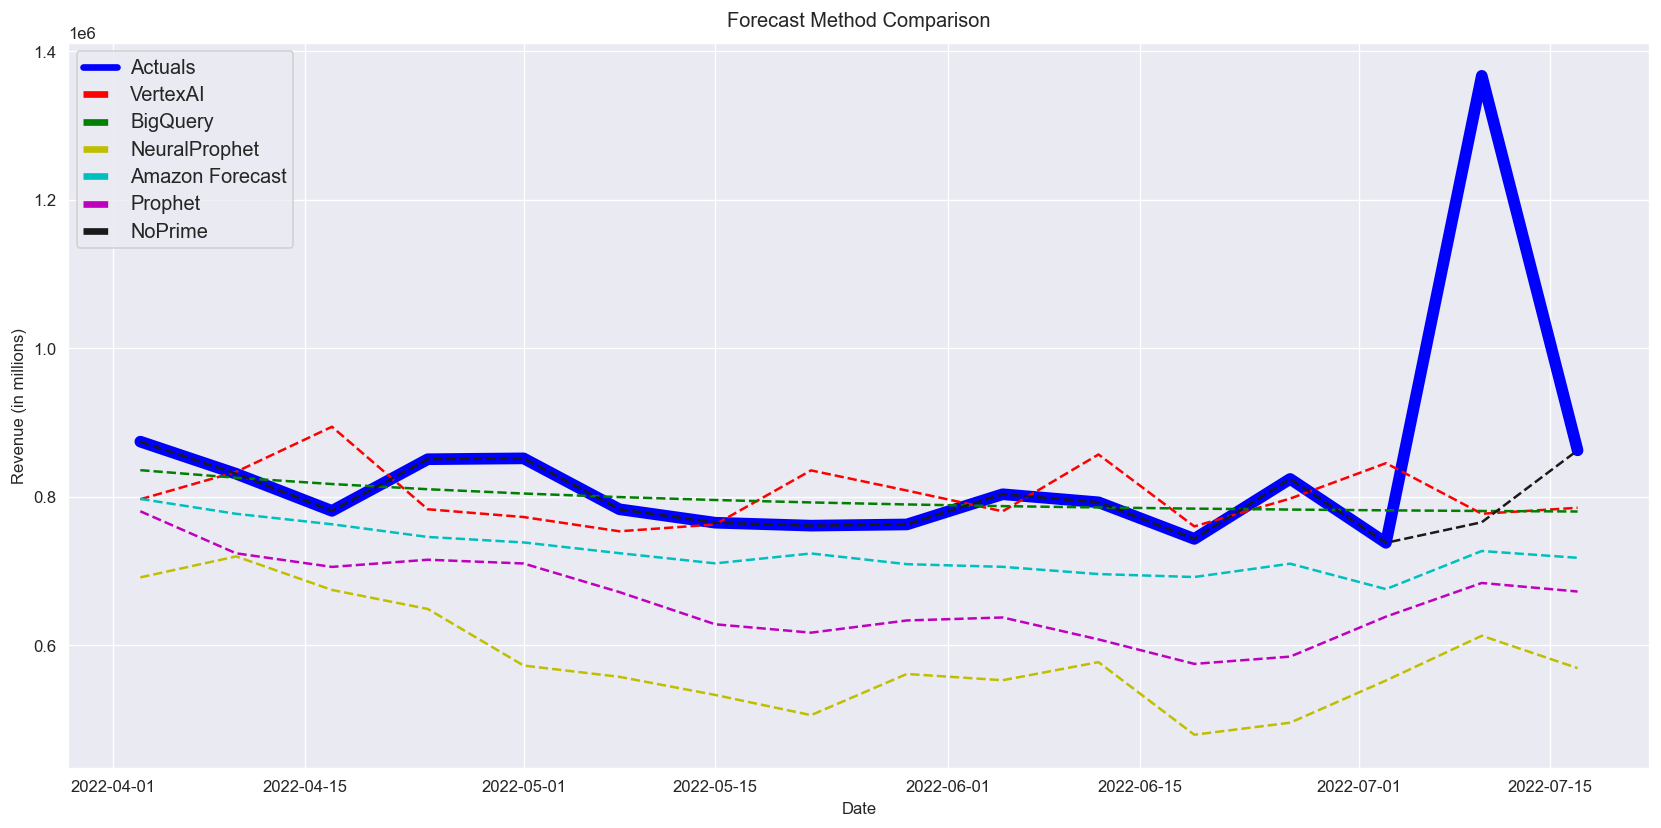

In [77]:
fig = plt.figure(figsize=(17, 8))
ax  = fig.add_subplot(111)
ax.plot(x, Actuals, c='b', label='Actuals', linewidth=7)
ax.plot(x, VertexAI, c='r', linestyle='dashed',  label='VertexAI')
ax.plot(x, BigQuery, c='g', linestyle='dashed', label='BigQuery')
ax.plot(x, NeuralProphet, c='y', linestyle='dashed', label='NeuralProphet')
ax.plot(x, Forecast, c='c', linestyle='dashed', label='Amazon Forecast')
ax.plot(x, Prophet, c='m', linestyle='dashed', label='Prophet')
ax.plot(x, NoPrime, color = '0.1', linestyle='dashed', label='NoPrime')
leg = plt.legend()
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.setp(leg_texts, fontsize='large')
plt.xlabel('Date')
plt.ylabel('Revenue (in millions)')
plt.title('Forecast Method Comparison')
plt.show()

Note that it's better to run this section only once, or the numbers will continue to double. I made a scalar for Prime Day by dividing the five highest sales day by the mean of all sales days. The division of the actual Prime Day by the scalar is what provides the value for the NoPrime value on Prime Day.


In [78]:
scalar = np.mean(df['sales'].nlargest(n=5)) / np.mean(df['sales'])
BigQuery_Prime = BigQuery
swap = BigQuery_Prime[14::2].values
BigQuery_Prime[14::2] = BigQuery_Prime[14::2] + swap
print(BigQuery_Prime[14::2])

Date
2022-07-10    1561033.98
Name: BigQuery, dtype: float64


The blue line, actuals are overlaid by a white dashed line, which is just the duplicated actuals with the scalar minimizing Prime Day.

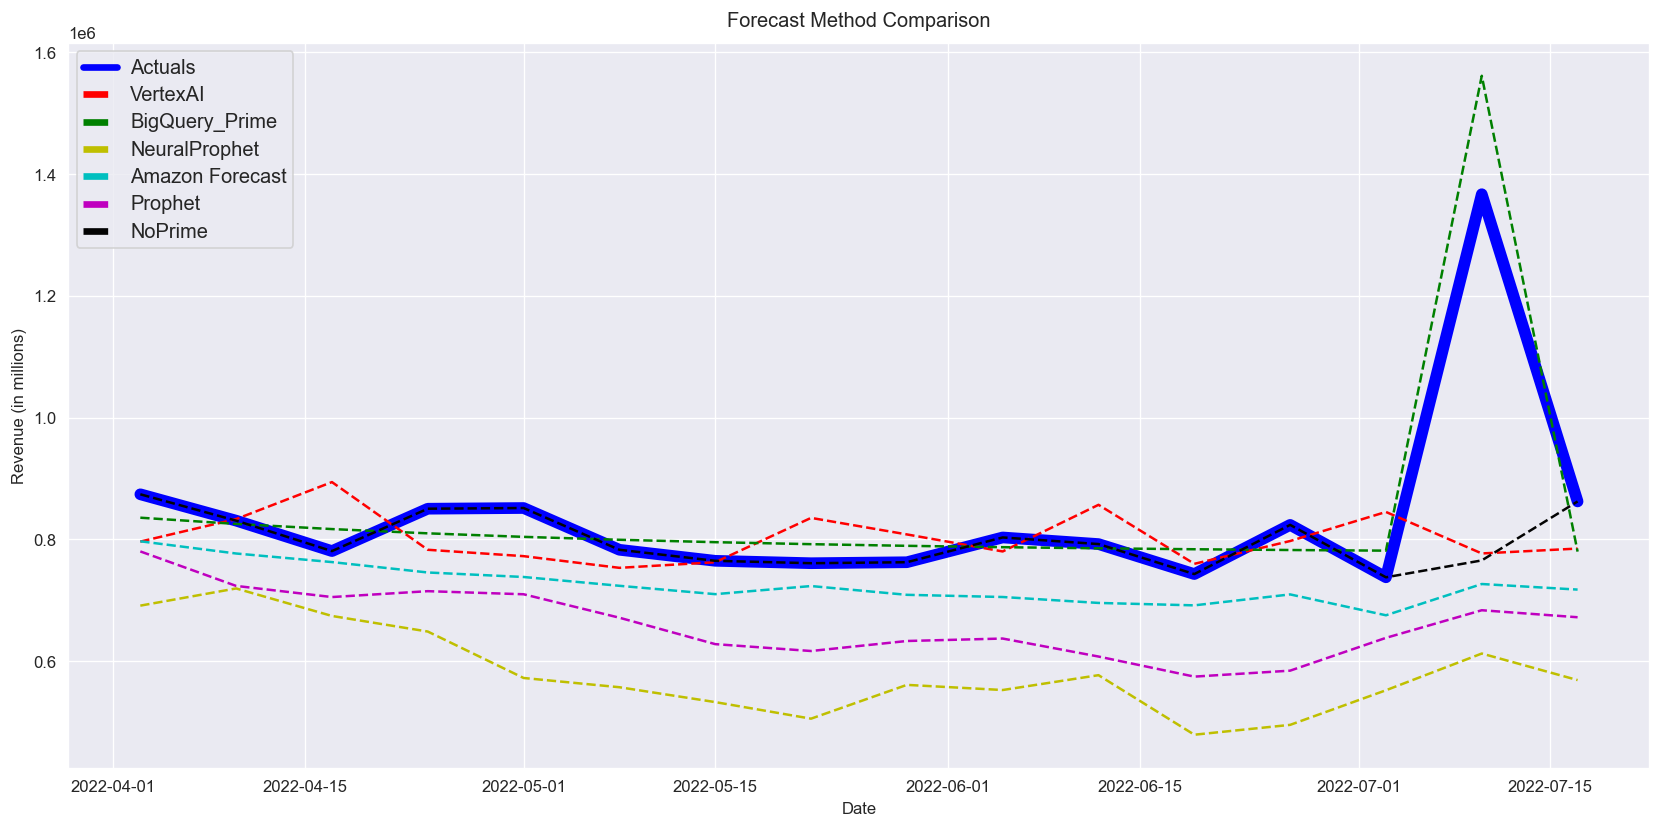

In [79]:
fig = plt.figure(figsize=(17, 8))
ax  = fig.add_subplot(111)
ax.plot(x, Actuals, c='b', label='Actuals', linewidth=7)
ax.plot(x, VertexAI, c='r', linestyle='dashed',  label='VertexAI')
ax.plot(x, BigQuery_Prime, c='g', linestyle='dashed', label='BigQuery_Prime')
ax.plot(x, NeuralProphet, c='y', linestyle='dashed', label='NeuralProphet')
ax.plot(x, Forecast, c='c', linestyle='dashed', label='Amazon Forecast')
ax.plot(x, Prophet, c='m', linestyle='dashed', label='Prophet')
ax.plot(x, NoPrime, color='.01', linestyle='dashed', label='NoPrime')
leg = plt.legend()
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.setp(leg_texts, fontsize='large')
plt.xlabel('Date')
plt.ylabel('Revenue (in millions)')
plt.title('Forecast Method Comparison')
plt.show()

In [80]:
dataframe = pd.DataFrame(error_frame)
dataframe.style.highlight_min(axis=1, color= 'blue')

,VertexAI,BigQuery,NeuralProphet,Prophet,Amazon_Forecast
MAPE,0.204768,0.188375,0.277085,0.194476,0.166718
MSE,28636691651.973862,23964438908.731773,44621174830.667694,22815165726.682362,19382612664.857674
MAE,113015.350537,103241.996937,192242.465088,125800.729525,95852.817975
RMSE,169223.791625,154804.518373,211237.247735,151046.899097,139221.451885


Just for some extra clarity, Amazon performed the best in MAPE, then BigQuery, then
Prophet, then VertexAI, and finally NeuralProphet.
For MSE, the order was the same.
For MAE. the only switchup was VertexAI and Prophet, which took 3 and 4th, respectively.
Finally, RMSE matched the order of the first two metrics.

To see how these metrics are cacaluated, see this article on MAPE:
https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

This on MSE: https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

This on MAE: https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error

Finally, we have RMSE (also known as RMS) documented here (Note: FB uses normalized
RMSE for their ML):
https://en.wikipedia.org/wiki/Root-mean-square_deviation

I would look at this article to make up your mind on pros and cons of each:
https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d

But I will point out some of the largest differences. For MAPE, or Mean Absolute
Percentage Error, the average error in low-demand periods have a disproporitionaly
large effect durring high-demand season.

MAE, or Mean Absolute Error, simply takes the absolute value of the difference between
the prediciton and actual observations, then averages them. It does suffer from scaling
issues, so it is often weighted appropriately.

Both MAE and MAPE are very similar: MAPE is an easier to understand metric, while MAE
is easier to understand at scale. Also, MAPE behaves poorly at zero.

Root-mean-square-deviation is, in its simplest case, with an unbiased estimator, the
same as the standard deviation. For ML purposes, minimizing RMSE is the best way to
compare one model to another.

##### Remember that this numbers do not exist in a vacuum; they are best at comparing one
##### model to another. Comparing RMSE and MAPE might be the first step, as one is
##### constrained and RMSE less so. Finally, none of these should be negative, or else
##### the model needs to be re-examined.